In [1]:
# 多GPU训练
%matplotlib inline
import torch
from torch import nn
from torch.nn import functional as F 
from d2l import torch as d2l

In [2]:
scale = 0.01
W1 = torch.randn(size=(20, 1, 3, 3)) * scale
b1 = torch.zeros(20)
W2 = torch.randn(size=(50, 20, 5, 5)) * scale
b2 = torch.zeros(50)
W3 = torch.randn(size=(800, 128)) * scale
b3 = torch.zeros(128)
W4 = torch.randn(size=(128, 10)) * scale
b4 = torch.zeros(10)
params = [W1, b1, W2, b2, W3, b3, W4, b4]

def lenet(X, params):
    h1_conv = F.conv2d(input=X, weight=params[0], bias=params[1])
    h1_activation = F.relu(h1_conv)
    h1 = F.avg_pool2d(input=h1_activation, kernel_size=(2, 2), stride=(2, 2))
    h2_conv = F.conv2d(input=h1, weight=params[2], bias=params[3])
    h2_activation = F.relu(h2_conv)
    h2 = F.avg_pool2d(input=h2_activation, kernel_size=(2, 2), stride=(2, 2))
    h2 = h2.reshape(h2.shape[0], -1)
    h3_linear = torch.mm(h2, params[4]) + params[5]
    h3 = F.relu(h3_linear)
    y_hat = torch.mm(h3, params[6]) + params[7]
    return y_hat

loss = nn.CrossEntropyLoss()

In [3]:
def get_params(params,device):
    new_params=[p.clone().to(device) for p in params]
    for p in new_params:
        p.requires_grad_()
    return new_params

new_params=get_params(params,d2l.try_gpu(0))
print("b1 weight:",new_params[1])
print("b1 grad:",new_params[1].grad)

b1 weight: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', requires_grad=True)
b1 grad: None


In [4]:
# allreduce
# 将所有向量相加，结果再广播回去
def allreduce(data):
    for i in range(1,len(data)):
        data[0][:]+=data[i].to(data[0].device)
    for i in range(1,len(data)):
        data[i]=data[0].to(data[i].device)


In [5]:
data=[torch.ones((1,2),device=d2l.try_gpu(i))*(i+1) for i in range(4)]
print("before allreduce:\n",data)
allreduce(data)
print("after allreduce:\n",data)

before allreduce:
 [tensor([[1., 1.]], device='cuda:0'), tensor([[2., 2.]], device='cuda:1'), tensor([[3., 3.]], device='cuda:2'), tensor([[4., 4.]], device='cuda:3')]
after allreduce:
 [tensor([[10., 10.]], device='cuda:0'), tensor([[10., 10.]], device='cuda:1'), tensor([[10., 10.]], device='cuda:2'), tensor([[10., 10.]], device='cuda:3')]


In [6]:
data=torch.arange(80).reshape(4,4,5)
devices=[torch.device("cuda:"+str(i))for i in range(4)]
split=nn.parallel.scatter(data,devices)

print("input",data)
print("load into:",devices)
print("output:",split)

input tensor([[[ 0,  1,  2,  3,  4],
         [ 5,  6,  7,  8,  9],
         [10, 11, 12, 13, 14],
         [15, 16, 17, 18, 19]],

        [[20, 21, 22, 23, 24],
         [25, 26, 27, 28, 29],
         [30, 31, 32, 33, 34],
         [35, 36, 37, 38, 39]],

        [[40, 41, 42, 43, 44],
         [45, 46, 47, 48, 49],
         [50, 51, 52, 53, 54],
         [55, 56, 57, 58, 59]],

        [[60, 61, 62, 63, 64],
         [65, 66, 67, 68, 69],
         [70, 71, 72, 73, 74],
         [75, 76, 77, 78, 79]]])
load into: [device(type='cuda', index=0), device(type='cuda', index=1), device(type='cuda', index=2), device(type='cuda', index=3)]
output: (tensor([[[ 0,  1,  2,  3,  4],
         [ 5,  6,  7,  8,  9],
         [10, 11, 12, 13, 14],
         [15, 16, 17, 18, 19]]], device='cuda:0'), tensor([[[20, 21, 22, 23, 24],
         [25, 26, 27, 28, 29],
         [30, 31, 32, 33, 34],
         [35, 36, 37, 38, 39]]], device='cuda:1'), tensor([[[40, 41, 42, 43, 44],
         [45, 46, 47, 48, 49],

In [7]:
def split_batch(X,y,devices):
    assert X.shape[0]==y.shape[0]
    return (
        nn.parallel.scatter(X,devices),
        nn.parallel.scatter(y,devices),
    )

In [8]:
# 小批量上实现多GPU训练
def train_batch(X,y,devices_params,devices,lr):
    X_shards,y_shards=split_batch(X,y,devices)
    ls=[loss(lenet(X_shard,device_W),y_shard).sum() 
    for X_shard,y_shard,device_W in zip(X_shards,y_shards,devices_params)]
    # 有一些串行(没有完成并行)
    # 看框架做的好不好
    for l in ls:
        l.backward()
    with torch.no_grad():
        for i in range(len(devices_params[0])):
            allreduce([devices_params[c][i].grad 
            for c in range(len(devices))])
    for param in devices_params:
        d2l.sgd(param,lr,X.shape[0])

In [9]:
def train(num_gpus, batch_size, lr):
    train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
    devices = [d2l.try_gpu(i) for i in range(num_gpus)]
    device_params = [get_params(params, d) for d in devices]
    num_epochs = 10
    animator = d2l.Animator('epoch', 'test acc', xlim=[1, num_epochs])
    timer = d2l.Timer()
    for epoch in range(num_epochs):
        timer.start()
        for X, y in train_iter:
            train_batch(X, y, device_params, devices, lr)
            torch.cuda.synchronize()#同步
        timer.stop()
        animator.add(epoch + 1, (d2l.evaluate_accuracy_gpu(
            lambda x: lenet(x, device_params[0]), test_iter, devices[0]),))
    print(f'test acc: {animator.Y[0][-1]:.2f}, {timer.avg():.1f} sec/epoch '
          f'on {str(devices)}')

test acc: 0.10, 1.6 sec/epoch on [device(type='cuda', index=0)]


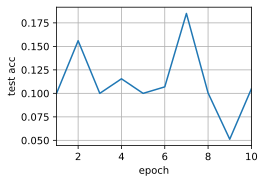

In [10]:
train(num_gpus=1, batch_size=256, lr=0.2)

test acc: 0.10, 1.5 sec/epoch on [device(type='cuda', index=0), device(type='cuda', index=1)]


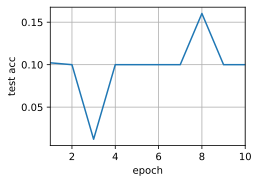

In [11]:
train(num_gpus=2, batch_size=512, lr=0.2)